In [14]:
import numpy as np
import pandas as pd
from pandas import DataFrame

In [15]:
from sklearn.datasets import load_boston
boston = load_boston()
X, y = np.matrix(boston.data), np.matrix(boston.target).T

In [16]:
print(X.shape, y.shape)

(506, 13) (506, 1)


In [17]:
# Solve linear regression, plot target and prediction
w = (np.linalg.inv(X.T*X)) * X.T * y
yh_lin = X*w
print(w.shape)
print(yh_lin.shape)

(13, 1)
(506, 1)


In [12]:
import matplotlib.pyplot as plt

<ipython-input-18-87fbe8c240fb>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(y, yh_lin, '.', Color='magenta')


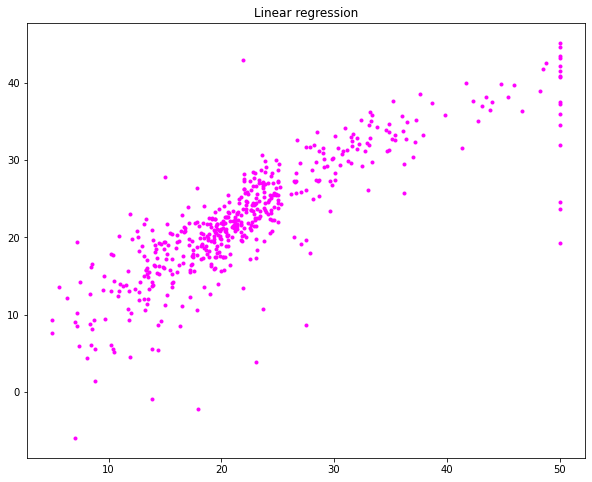

In [18]:
plt.figure(figsize=(10,8))
plt.plot(y, yh_lin, '.', Color='magenta')
plt.title('Linear regression')
plt.show()

In [19]:
# J = 20basis functions obtained by k-means clustering
# sigma set to standard deviation of entire data
from sklearn.cluster import KMeans



In [23]:
N = X.shape[0]
def rbf(J):
    kmeans = KMeans(n_clusters=J, random_state=0).fit(X)
    sig = np.std(X)
    # Construct design matrix
    U = np.zeros((N,J))
    for i in range(N):
        for j in range(J):
            U[i][j] = np.linalg.norm(X[i] - kmeans.cluster_centers_[j])
    # Solve RBF model, predict and plot
    w = np.dot((np.linalg.inv(np.dot(U.T,U))), U.T) @ y
    yh_rbf = U*w
    print('J= ',J, 'error= ',np.linalg.norm(y-yh_rbf))
    return yh_rbf
    

In [24]:
J = 20
yh_rbf = rbf(J)

J=  20 error=  168.29717660792846


In [25]:
for J in range(20, 506, 40):
    yh_rbf = rbf(J)
    
print(np.linalg.norm(y-yh_lin))

J=  20 error=  168.29717660792846
J=  60 error=  126.95202593482095
J=  100 error=  103.59954870107
J=  140 error=  89.88377155409842
J=  180 error=  85.67616825489893
J=  220 error=  75.12408772027385
J=  260 error=  66.70212077607874
J=  300 error=  53.16376051586551
J=  340 error=  43.04460699452855
J=  380 error=  33.50691772992206
J=  420 error=  23.80235873094326
J=  460 error=  13.611185240581923
J=  500 error=  6.618682788340571
110.58049674804326


<ipython-input-27-96a7bb306d3d>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(y, yh_rbf, '.', Color='cyan', label=u'J=500')


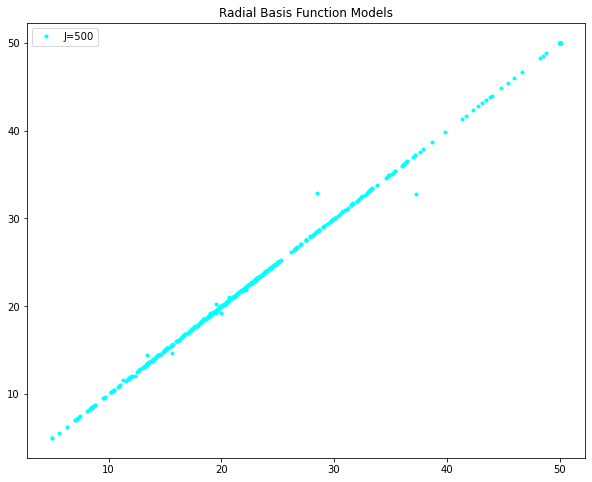

In [27]:
plt.figure(figsize=(10,8))
plt.plot(y, yh_rbf, '.', Color='cyan', label=u'J=500')
plt.title('Radial Basis Function Models')
plt.legend()
plt.show()

In [28]:
import random
from sklearn.preprocessing import normalize

In [29]:
###SGD update w

def sgd_rbf(X, y):
    N = X.shape[0]
    w0 = np.random.randn(X.shape[1],1)
    E0 = np.linalg.norm(y-X@w0)
    
    MaxIter = 5000
    lRate = 0.03
    Eplot = np.zeros((MaxIter,1))
    
    y_sgd = np.random.randn(y.shape[0],1)
    wIter = w0
    
    for iter in range(MaxIter):
        j = np.floor(np.random.rand()*N).astype(int)
        xj = X[j,:]
        yj = y[j,:]
        yPred = xj@wIter
        wIter = wIter-(lRate*(yPred-yj)*xj).T
        Eplot[iter] = np.linalg.norm(y-X@wIter)
    print(np.linalg.norm(y-X@wIter))
    y_sdg = X@wIter
    return Eplot, y_sgd
    

178.2516998592064


Text(0.5, 1.0, 'SGD-w in Radial Basis Function Models')

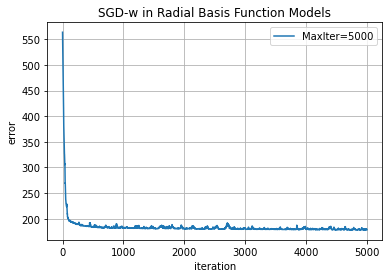

In [31]:
X = normalize(X)
Eplot, y_sgd = sgd_rbf(X, y)
fig,ax = plt.subplots()
ax.plot(Eplot, label=u'MaxIter=5000')
ax.set_xlabel("iteration")
ax.set_ylabel("error")
ax.grid(True)
plt.legend()
ax.set_title("SGD-w in Radial Basis Function Models")

<ipython-input-32-323919658665>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(y, y_sgd, '.', Color='cyan', label=u'Iter=5000')


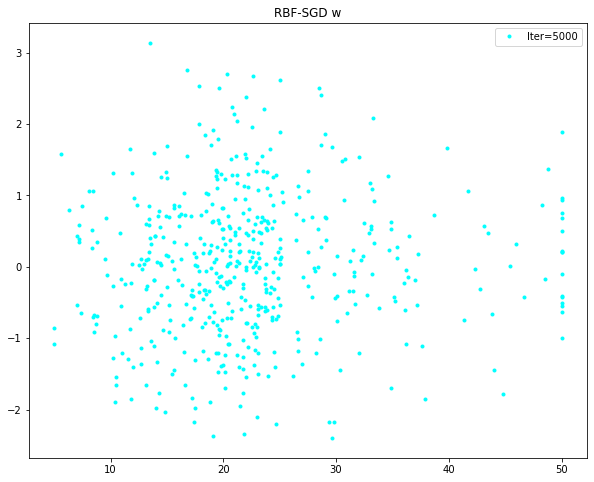

In [32]:
plt.figure(figsize=(10,8))
plt.plot(y, y_sgd, '.', Color='cyan', label=u'Iter=5000')
plt.title('RBF-SGD w')
plt.legend()
plt.show()

In [33]:
class RBFnetwork(object):
    
    def __init__(self, hidden_nums, r_w, r_c, r_sigma):
        self.h = hidden_nums        
        self.w = 0                  #weights
        self.c = 0                  #center 
        self.sigma = 0              
        self.r = {"w":r_w, 
                  "c":r_c, 
                  "sigma":r_sigma}  #learning rate
        self.errList = []           #error list
        self.n_iters = 0            #iteration
        self.tol = 1.0e-5           #max excepted error
        self.X = 0                  #training data
        self.y = 0                  #target
        self.n_samples = 0          
        self.n_features = 0         
        

    def change(self, sigma, X, c):
        J = 13

        kmeans = KMeans(n_clusters=J, random_state=0).fit(X)
        sig = np.std(X)
        # Construct design matrix
        U = np.zeros((self.n_samples,J))
        for i in range(self.n_samples):
            for j in range(J):
               U[i][j] = np.linalg.norm(X[i] - kmeans.cluster_centers_[j])
        newX = U
        
        return newX
    
    def init(self):
        sigma = np.random.random((self.h, 1))               #(h,1)
        c = np.random.random((self.h, self.n_features))     #(h,n)
        w = np.random.random((13+1, 1))                 #(h+1,1) 改成了21 J=20
        return sigma, c, w
    
    #Add a list of intercept items to the input of the output layer
    def addIntercept(self, X):
        return np.hstack((X,np.ones((self.n_samples,1))))

    #Calculate the total error
    def calSSE(self, prey, y):
        return 0.5*(np.linalg.norm(prey - y))**2
    
    #Find the square of the L2 norm
    def l2(self, X, c):
        m,n = np.shape(X)
        newX = np.zeros((m, len(c)))
        for i in range(len(c)):
            newX[:,i] = np.linalg.norm((X-c[i]), axis=1)**2
        return newX
    
    
    def train(self, X, y, iters):
        n = X.shape[1]
        m = X.shape[0]
        self.X = X
        self.y = y.reshape(-1,1)
        self.n_samples, self.n_features = X.shape
        sigma, c, w = self.init()   
        
       
        
        #初始化参数
        for i in range(iters):
            ##正向计算过程
            hi_output = self.change(sigma,X,c)              #(m ,h 13)
            #hi_output = X
            yi_input = self.addIntercept(hi_output)         #(m 506 ,h+1 14)，
            #print()
            yi_output = np.dot(yi_input, w)                 #(m,1)
            error = self.calSSE(yi_output, y)               
            if error < self.tol:
                break
            self.errList.append(error)                      
            ##Error back propagation process
            deltaw = np.dot(yi_input.T, (yi_output-y))      #(h+1,m)x(m,1)
            w -= self.r['w']*deltaw/len(yi_input)
            
            deltasigma = np.divide(np.multiply(np.dot(np.multiply(hi_output,self.l2(X,c)).T, \
                        (yi_output-y)), w[:-1]), sigma**3)  #(h,m)x(m,1)
            sigma -= self.r['sigma']*deltasigma/self.n_samples
            deltac1 = np.divide(w[:-1],sigma**2)            #(h,1)
            deltac2 = np.zeros((1,n))                       #(1,n)
            for j in range(m):
                A = np.dot(hi_output[j], X[j]-c)
                deltac2 += (yi_output-y)[j]*A
            deltac = np.dot(deltac1,deltac2)                #(h,1)x(1,n)
            c -= self.r['c']*deltac/self.n_samples
        self.c = c
        self.w = w
        self.sigma = sigma
        self.n_iters = i
        
    
    def predict(self, X):
        yi_input = self.addIntercept(X) #The output layer input (m 506, h+1 14), because it is linearly weighted, so the bias is added
        #print(self.w[:3,:])
        yi_output = np.dot(yi_input, self.w)  #(m 506,1)
        #print('yi_out', yi_output[:3,:])
        return yi_output
    

In [34]:
from sklearn.preprocessing import normalize
from sklearn.datasets import load_boston

boston = load_boston()
X, y = np.matrix(boston.data), np.matrix(boston.target).T
X = normalize(X)   
# hidden_nums, r_w, r_c, r_sigma
rbf = RBFnetwork(X.shape[1], 0.6, 0.2, 0.2)
rbf.train(X, y, 1000)  

yi_output = rbf.predict(X)



In [36]:
print('error',np.linalg.norm(y-yi_output) )

error 268.38576023391647


<ipython-input-37-c81365f26957>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(y, yi_output, '.', Color='cyan', label=u'Iter=1000')


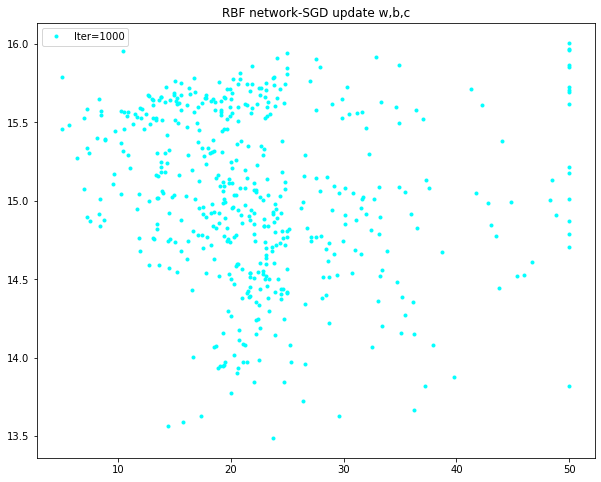

In [37]:
plt.figure(figsize=(10,8))
plt.plot(y, yi_output, '.', Color='cyan', label=u'Iter=1000')
plt.title('RBF network-SGD update w,b,c')

plt.legend()
plt.show()